<a href="https://colab.research.google.com/github/jpescobarn/AnaliticaDatos/blob/master/ANAL%C3%8DTICA_DE_DATOS_EJERCICIO_FINAL_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analítica de Datos 2020-2
### Ejercicio Final  
### Red Profunda 
#### Tomás Giraldo Agudelo - Juan Pablo Escobar Naranjo
--- 


## Objetivo

###Entrenar y evaluar un esquema de aprendizaje profundo mediante **CNNs**, Justificando la arquitectura empleada, tipo de capas, activaciones, inicializaciones, normalilzaciones, entre otros. Interpretar los resultados de la red y comparar los resultados obtenidos con clasificador logístico y una SVM lineal.


In [20]:
!pip install joblib


## Proceso para Clase lfw_People 

### Se realiza todo el proceso para estudiar la base de datos de los rostros de los políticos, 

In [21]:
import os
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import  BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#%% Analisis exploratorio basico - base de datos housing
def pre_exploratorio(Xtrain_pre,ytrain_pre,path_img,col_sal,w,h,Np=None):
    #exploratorio basico -> Normalizar + reduccion de dimensionalidad
    normalizar = StandardScaler()
    #escoger aleatoriamente puntos para evitar costo computacional - analisis inicial
    if Np == None: Np = len(Xtrain_pre.index)
    
    ind = np.random.randint(0,len(Xtrain_pre.index),Np) #escoger subconjunto de datos
    
    Xz = normalizar.fit_transform(Xtrain_pre.iloc[ind,:])
    yc = ytrain_pre[ind].reshape(-1)
    
    #reduccion de dimension con pca y tsne
    red_pca = PCA()

    Xred_pca = pd.DataFrame(red_pca.fit_transform(Xz))
  
    #Relevancia por variabilidad
    var_ret = 0.95
    rel_vec,Mv,ind_rel = rel_pca(red_pca,var_ret)
    
    #graficar
    sval = 30
    #pca 2D
    Xred_pca.plot(kind="scatter",x=0,y=1,
               c = yc, s=sval, label = col_sal,
              colormap = "jet",colorbar=True, sharex=False)    
    plt.title('PCA 2D')
    plt.xlabel('Componente principal 1')
    plt.ylabel('Componente principal 2')
    plt.show()
    
    #relevancia pca 2D     
    plt.imshow(rel_vec.reshape(w,h),cmap='jet')
    plt.ylabel('Relevancia PCA - eigenfaces')
    plt.title('RELEVANCIA PCA - eigenfaces, var_ret=%.2f' % (var_ret))
    plt.colorbar()
   
    plt.show()

    
    return True
#%% relevancia por variabilidad con pca
def rel_pca(red,var_exp):
    Mv = np.min(np.where(np.cumsum(red.explained_variance_ratio_)
                         >var_exp))
    M,P = red.components_.shape
    rel_vec = np.zeros((P))
    for i in range(Mv):
        rel_vec += abs(red.explained_variance_ratio_[i]*red.components_[i,:])
    
    rel_vec = rel_vec/sum(rel_vec)
    rel_vec = rel_vec - min(rel_vec)
    rel_vec = rel_vec/max(rel_vec)
    
    ind_rel = rel_vec.argsort()[::-1]
    return rel_vec, Mv,ind_rel

#%%  guardar figuras
#from google.colab import files
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path) 
    
import seaborn as sns

def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):   
    lw = 2

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot  ROC curvas
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

    
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

    
#  ROC curva y ROC area para cada clase
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes
    



def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #  Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [22]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
#base de datos
from sklearn.datasets import fetch_lfw_people
#https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

%matplotlib inline
#descargar base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

#ejemplo imagen en base de datos
#print('Dimensiones base de datos: \n',lfw_people.images.shape)
#plt.imshow(lfw_people.images[30,:,:],cmap='gray')

#print('Clases base de datos: \n',lfw_people['target_names'])
#print(lfw_people.images[30,:,:])

Dimensiones tipo pandas:  (1288, 1850)


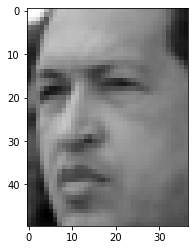

In [23]:
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
plt.imshow(np.array(Xdata.iloc[0,:]).reshape(lfw_people.images.shape[1],lfw_people.images.shape[2]),cmap='gray')


In [24]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3) #fijar en 0.3 para entrenar -- 0.95 para demostrar funcionalidad del código

Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
849,0.401307,0.479739,0.623529,0.694118,0.695425,0.669281,0.653595,0.650980,0.661438,0.667974,0.657516,0.635294,0.654902,0.661438,0.654902,0.640523,0.653595,0.678431,0.692810,0.711111,0.725490,0.722876,0.728105,0.735948,0.739869,0.732026,0.725490,0.701961,0.671895,0.671895,0.712418,0.742484,0.730719,0.700654,0.586928,0.369935,0.307190,0.415686,0.482353,0.616993,...,0.177778,0.193464,0.222222,0.972549,0.975163,0.976471,0.945098,0.813072,0.626144,0.503268,0.481046,0.496732,0.498039,0.471895,0.410457,0.394771,0.454902,0.515033,0.560784,0.562091,0.550327,0.542484,0.547712,0.562091,0.575163,0.577778,0.576471,0.580392,0.593464,0.622222,0.636601,0.619608,0.773856,0.915033,0.937255,0.911111,0.513726,0.172549,0.196078,0.216993
1122,0.558170,0.579085,0.661438,0.781699,0.875817,0.890196,0.882353,0.866667,0.861438,0.857516,0.828758,0.816993,0.822222,0.828758,0.833987,0.824837,0.827451,0.816993,0.820915,0.844444,0.862745,0.867974,0.853595,0.857516,0.865359,0.852288,0.822222,0.783007,0.739869,0.716340,0.721569,0.694118,0.639216,0.577778,0.441830,0.320261,0.349020,0.551634,0.597386,0.724183,...,0.541176,0.203922,0.230065,0.396078,0.891503,0.986928,0.951634,0.833987,0.478431,0.350327,0.362092,0.371242,0.379085,0.375163,0.373856,0.371242,0.369935,0.358170,0.342484,0.342484,0.350327,0.358170,0.362092,0.364706,0.366013,0.359477,0.354248,0.339869,0.338562,0.346405,0.355556,0.396078,0.428758,0.481046,0.517647,0.790850,0.963399,0.558170,0.198693,0.215686
970,0.439216,0.461438,0.528105,0.688889,0.832680,0.849673,0.843137,0.806536,0.788235,0.788235,0.788235,0.779085,0.767320,0.767320,0.771242,0.780392,0.798693,0.810458,0.820915,0.816993,0.814379,0.811765,0.798693,0.767320,0.745098,0.752941,0.775163,0.785621,0.779085,0.766013,0.789542,0.790850,0.743791,0.713726,0.690196,0.652288,0.628758,0.470588,0.505882,0.568627,...,0.647059,0.687582,0.718954,0.248366,0.233987,0.220915,0.223529,0.220915,0.257516,0.649673,0.811765,0.630065,0.415686,0.322876,0.227451,0.186928,0.181699,0.171242,0.159477,0.154248,0.169935,0.184314,0.180392,0.183007,0.188235,0.198693,0.205229,0.194771,0.197386,0.207843,0.196078,0.175163,0.172549,0.175163,0.292810,0.552941,0.641830,0.666667,0.720261,0.742484
793,0.545098,0.569935,0.522876,0.498039,0.525490,0.526797,0.541176,0.572549,0.576471,0.601307,0.650980,0.711111,0.754248,0.780392,0.790850,0.796078,0.805229,0.816993,0.796078,0.792157,0.831373,0.847059,0.841830,0.833987,0.823529,0.827451,0.814379,0.793464,0.762091,0.734640,0.738562,0.726797,0.712418,0.666667,0.658824,0.637909,0.585621,0.563399,0.569935,0.501961,...,0.653595,0.308497,0.043137,0.074510,0.082353,0.103268,0.430065,0.590850,0.575163,0.593464,0.603922,0.590850,0.551634,0.449673,0.308497,0.226144,0.213072,0.253595,0.265359,0.265359,0.307190,0.343791,0.335948,0.324183,0.322876,0.291503,0.328105,0.358170,0.275817,0.149020,0.368627,0.764706,0.861438,0.816993,0.764706,0.760784,0.767320,0.681046,0.372549,0.069281
39,0.060131,0.094118,0.205229,0.266667,0.292810,0.282353,0.343791,0.441830,0.466667,0.494118,0.511111,0.508497,0.513726,0.525490,0.556863,0.581699,0.562091,0.550327,0.560784,0.594771,0.626144,0.650980,0.670588,0.692810,0.686275,0.670588,0.654902,0.627451,0.592157,0.560784,0.556863,0.538562,0.475817,0.338562,0.155556,0.107190,0.086275,0.065359,0.109804,0.223529,...,0.549020,0.232680,0.228758,0.230065,0.243137,0.254902,0.236601,0.216993,0.185621,0.201307,0.198693,0.139869,0.115033,0.116340,0.186928,0.277124,0.343791,0.335948,0.341176,0.393464,0.416993,0.416993,0.439216,0.448366,0.473203,0.475817,0.439216,0.414379,0.413072,0.443137,0.450980,0.433987,0.491503,0.670588,0.882353,0.960784,0.823529,0.379085,0.214379,0.222222


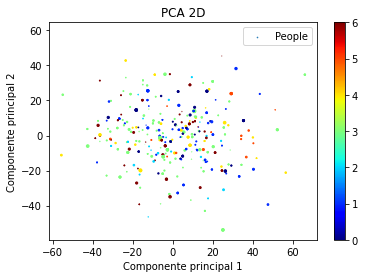

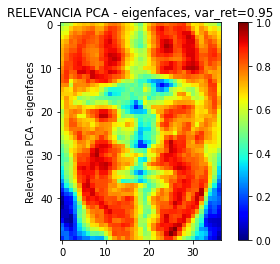

True

In [25]:
#%% Paso 3 : Analisis exploratorio
#preproceso entrada  y salida para analisis exploratorio
img_path = '' #para guardar from google.colab import files plt.savefig("abc.png") files.download("abc.png") 
pre_exploratorio(Xtrain,ytrain,img_path,'People',lfw_people.images.shape[1],lfw_people.images.shape[2])

## Modelos por gridsearchCV utilizando pipeline



### Se seleccionan tres modelos a evaluar para el programa, **PCA_Logistic**, **PCA_SGD** y **SVCrbf**, cuyos parámetros fueron establecidos aleatoriamente en búsqueda de conveniencia y buenos resultados.

In [64]:
#%% Paso 4 : Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#from sklearn.externals import joblib #https://joblib.readthedocs.io/en/latest/
import joblib

steps=[[('rep',  PCA()),
        ('cla', LogisticRegression())],
       [('rep',  PCA()),
        ('cla', SGDClassifier())],
        [('cla', SVC())]
      ]
parameters = [{
              'rep__n_components' : [0.5, 0.6, 0.7, 0.8, 0.9],              
              'cla__C': [0.5,1],
              },
              {
              'rep__n_components' : [0.5, 0.6, 0.7,0.8,0.9],              
              'cla__alpha': [0.0001,0.001, 0.01, 0.1],
              },
              {
                               
             'cla__C': [0.1,1,100,500,1e3],
             'cla__gamma': [0.01, 0.1, 1,10, 100,1e3]     
             }
             ]

label_models = ['PCA_Logistic','PCA_SGD', 'SVCrbf']

best_model = []
filename = ''#'resultados/people_comp'
for i in range(len(steps)):
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='balanced_accuracy',verbose=10)
    grid_search.fit(Xtrain, ytrain)

    #mejor modelo entrenado
    best_model += [grid_search.best_estimator_]
    joblib.dump(best_model,filename+".pkl")

print('Mejores modelos:\n')
best_model

modelo 1/3
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.4s finished


modelo 2/3
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.3s finished


modelo 3/3
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  3

Mejores modelos:



[Pipeline(memory=None,
          steps=[('rep',
                  PCA(copy=True, iterated_power='auto', n_components=0.9,
                      random_state=None, svd_solver='auto', tol=0.0,
                      whiten=False)),
                 ('cla',
                  LogisticRegression(C=1, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False), Pipeline(memory=None,
          steps=[('rep',
                  PCA(copy=True, iterated_power='auto', n_components=0.9,
                      random_state=None, svd_solver='auto', tol=0.0,
                      whiten=False)),
 

## Se presentan las matrices de confusión generadas por cada uno de los modelos, donde se puede apreciar que los tres modelos obtienen porcentajes de acierto bastante similares, cercanos a un 80%

# Calcular rendimiento en cojunto de test

Evaluando modelo 1/3


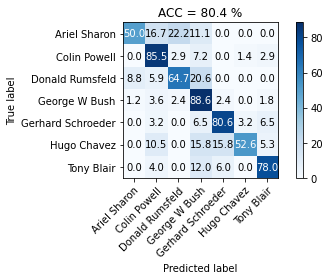

                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.50      0.56        18
     Colin Powell       0.79      0.86      0.82        69
  Donald Rumsfeld       0.69      0.65      0.67        34
    George W Bush       0.85      0.89      0.87       166
Gerhard Schroeder       0.71      0.81      0.76        31
      Hugo Chavez       0.83      0.53      0.65        19
       Tony Blair       0.83      0.78      0.80        50

         accuracy                           0.80       387
        macro avg       0.76      0.71      0.73       387
     weighted avg       0.80      0.80      0.80       387

Evaluando modelo 2/3


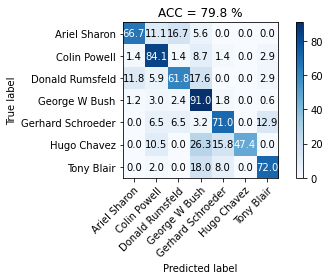

                   precision    recall  f1-score   support

     Ariel Sharon       0.63      0.67      0.65        18
     Colin Powell       0.81      0.84      0.82        69
  Donald Rumsfeld       0.68      0.62      0.65        34
    George W Bush       0.84      0.91      0.88       166
Gerhard Schroeder       0.67      0.71      0.69        31
      Hugo Chavez       1.00      0.47      0.64        19
       Tony Blair       0.82      0.72      0.77        50

         accuracy                           0.80       387
        macro avg       0.78      0.71      0.73       387
     weighted avg       0.80      0.80      0.79       387

Evaluando modelo 3/3


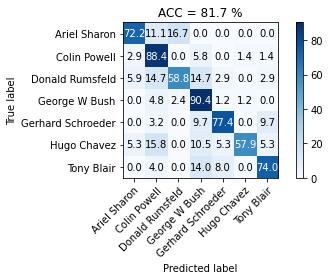

                   precision    recall  f1-score   support

     Ariel Sharon       0.72      0.72      0.72        18
     Colin Powell       0.74      0.88      0.81        69
  Donald Rumsfeld       0.74      0.59      0.66        34
    George W Bush       0.88      0.90      0.89       166
Gerhard Schroeder       0.75      0.77      0.76        31
      Hugo Chavez       0.79      0.58      0.67        19
       Tony Blair       0.86      0.74      0.80        50

         accuracy                           0.82       387
        macro avg       0.78      0.74      0.76       387
     weighted avg       0.82      0.82      0.81       387



In [65]:
#%% Paso 5: evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %d/%d' % (i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)
     
    plot_confusion_matrix(
                          ytest, ytest_e, 
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()                      
    plt.show()
    
    cr = classification_report(
                               ytest, ytest_e, 
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )                          
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

Evaluando ROC modelo 1/3


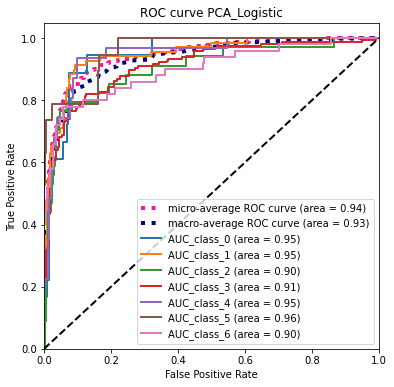

Evaluando ROC modelo 2/3


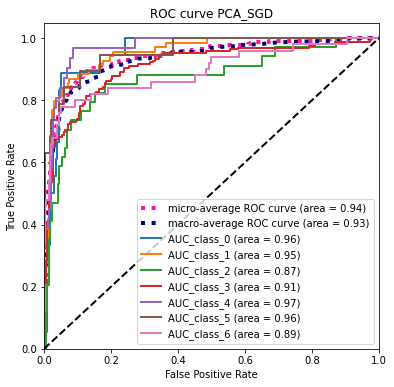

Evaluando ROC modelo 3/3


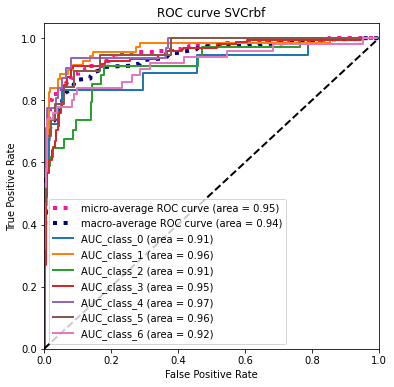

In [66]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando ROC modelo %d/%d' % (i+1,len(my_model_loaded)))
    ytest_score = my_model_loaded[i].decision_function(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)
    

## Preproceso

(1288,)
Hugo Chavez


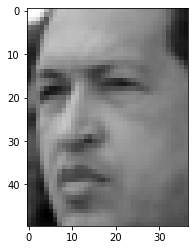

In [67]:
Xdata = lfw_people.images
y = lfw_people.target
plt.imshow(Xdata[0],cmap='gray')
print(y.shape)
print(lfw_people.target_names[y[0]])

In [68]:
x_data= np.expand_dims(Xdata, axis=3)

x_train_full, x_test, y_train_full, y_test = train_test_split(x_data,y,test_size=0.2, random_state=42)

x_train, x_valid, y_train, y_valid = train_test_split(x_train_full,y_train_full,test_size=0.3)


In [69]:
print(x_train.shape)
print(lfw_people.data.shape)
y_train.shape

(721, 50, 37, 1)
(1288, 1850)


(721,)

## Se define el modelo a seguir de la red Neuronal 

In [70]:
from functools import partial
import tensorflow as tf
from tensorflow import keras

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=3, input_shape=[lfw_people.images.shape[1], lfw_people.images.shape[2], 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    #DefaultConv2D(filters=256),
    #keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=500, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=100, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=7, activation='softmax'),
])

In [71]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Arquitectura seleccionada para la Red: Se establecen 4 capas convolucionales para extraer las características de los rostros de la base de datos, seguido de capas maxpooling para reducir los tamaños de la imagen, luego de las capas de características se agregan las capas de clasificación, capas densas una con 500 neuronas y otra con 100 neuronas, entre capas ponemos capas de dropout para evitar el sobre ajuste de la red.


In [72]:
#Construcción de los hiperparametros

# Se crea el modelo
# Parametros e hiperparametros
learning_rate=0.001
num_epoch = 100
batch     = 128

#optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)
#optimizer = tf.keras.optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999) 
#optimizer = tf.keras.optimizers.Adam(lr=learning_rate) 
optimizer = tf.keras.optimizers.SGD(lr=learning_rate, clipvalue=1.0)


model.summary()

# Se compila el modelo
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=num_epoch,
                      validation_data=(x_valid,y_valid))

score_test = model.evaluate(x_test, y_test, batch_size=batch)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 37, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 18, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 18, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 9, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 9, 128)        147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 4, 128)         1


### El número de épocas fue seleccionado como 100, teniendo en cuenta que según los resultados, la exactitud mantiene una relación directamente proporcional con las épocas, y que la función de error disminuye a medida que la exactitud aumenta. Se usa un optimizador no tan veloz, pero cuyo funcionamiento es eficiente para la tarea. 

### La tasa de aprendizaje, es la tasa con la que el optimizador aprende, este valor es el que mejor se acomoda. El lote o batch, define el número de ejemplos que se van a propagar en la red, obteniendo los mejores resultados con 128.

In [73]:
# ### Resumen de los parámetros, historial, y medidas de Loss y Accuracy

print('Resumen de la ejecución:\n')
print('Parámetros : ',history.params)
print('Claves que se calcularon : ',history.history.keys())

print('\nTest Loss:', score_test[0])
print('Test Accuracy: {:.2f}%'.format(100 * score_test[1]))

Resumen de la ejecución:

Parámetros :  {'verbose': 1, 'epochs': 100, 'steps': 23}
Claves que se calcularon :  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Test Loss: 0.745349645614624
Test Accuracy: 80.23%


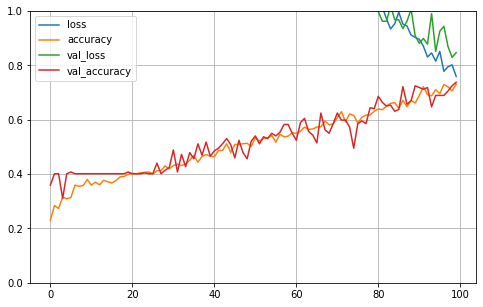

In [74]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig('grafica_train_validation_dropout.pdf', format='pdf', dpi=300)
#save_fig("keras_learning_curves_plot")
plt.show()


## La red neuronal establecida, con los parámetros mencionados anteriormente, arroja como resultado un acierto de aproximadamente un 80%. La función de pérdida fue seleccionada porque permite tener más de dos opciones en la última capa densa.

## El modelo que arrojó mejores resultados fue el modelo 3, SVCrbf, que obtuvo al rededor de un 80% de acierto en la problemática del reconocimiento de los rostros de los políticos. La Red Neuronal creada, obtuvo un porcentaje también superior al 80%% de acierto, lo que infiere que su desarrollo y aplicación fue exitoso.